In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

## Data Preprocessing

In [13]:
def create_samples(data, time_steps=12):
  X, y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps)])
    y.append(data[i + time_steps])
  return np.array(X), np.array(y)

### SPEI-6

#### Load Data

In [14]:
spei6_df = pd.read_csv('/content/SPEI_6_MonthTimescale_1950_2013_Fresno.csv')
spei6_df.head(5)

,time,lon,lat,spei
0,1950-01-16,-119.75,36.75,-0.177393
1,1950-02-15,-119.75,36.75,-0.520186
2,1950-03-16,-119.75,36.75,-0.425508
3,1950-04-16,-119.75,36.75,-0.482449
4,1950-05-16,-119.75,36.75,-0.595851


In [15]:
spei6_df.isnull().sum()

,0
time,0
lon,0
lat,0
spei,0


#### Normalize Data

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
spei6_df['spei'] = scaler.fit_transform(spei6_df[['spei']])
spei6_df.head(5)

,time,lon,lat,spei
0,1950-01-16,-119.75,36.75,-0.172372
1,1950-02-15,-119.75,36.75,-0.313809
2,1950-03-16,-119.75,36.75,-0.274744
3,1950-04-16,-119.75,36.75,-0.298238
4,1950-05-16,-119.75,36.75,-0.345028


#### Get Data Samples

In [17]:
time_steps = 6
X, y = create_samples(spei6_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape)
print(y.shape)

for i in range(len(X)):
  if (i == 2):
    break
  print(X[i], y[i])

(762, 6, 1)
(762,)
[[-0.1723716 ]
 [-0.31380863]
 [-0.27474426]
 [-0.29823832]
 [-0.3450278 ]
 [-0.25576174]] -0.4100309390992742
[[-0.31380863]
 [-0.27474426]
 [-0.29823832]
 [-0.3450278 ]
 [-0.25576174]
 [-0.41003094]] -0.46355073071756764


In [18]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size : train_size + val_size], y[train_size : train_size + val_size]
X_test, y_test = X[train_size + val_size :], y[train_size + val_size :]


print(f"Training splits (80%):  X_train = {X_train.shape} | y_train = {y_train.shape}")
print(f"Validation splits (10%):  X_val = {X_val.shape} | y_val = {y_val.shape}")
print(f"Test splits (10%):  X_test = {X_test.shape} | y_test = {y_test.shape}")

Training splits (80%):  X_train = (609, 6, 1) | y_train = (609,)
Validation splits (10%):  X_val = (76, 6, 1) | y_val = (76,)
Test splits (10%):  X_test = (77, 6, 1) | y_test = (77,)


In [19]:
X_train[0], y_train[0]  # example sample

(array([[-0.1723716 ],
        [-0.31380863],
        [-0.27474426],
        [-0.29823832],
        [-0.3450278 ],
        [-0.25576174]]),
 -0.4100309390992742)

In [20]:
y_test.max(), y_test.min()

(0.6238424759993554, -0.8834321867100817)

### Model Training

In [21]:
keras.utils.set_random_seed(42) # for reproducibility

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model = Sequential()
LSTM_model.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
LSTM_model.add(LSTM(units=64, activation='relu'))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = LSTM_model.fit(X_train,
                         y_train,
                         batch_size=16,
                         validation_data=(X_val, y_val),
                         epochs=50,
                         verbose=1, # just determines how much info to display for each epoch
                         shuffle=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1464 - val_loss: 0.1167
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1224 - val_loss: 0.0894
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0915 - val_loss: 0.0722
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0776 - val_loss: 0.0641
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0714 - val_loss: 0.0555
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0529 - val_loss: 0.0594
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0606 - val_loss: 0.0540
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0527 - val_loss: 0.0545
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0545 - val_loss: 0.0520
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0505 - val_loss: 0.0517
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0506 - val_loss: 0.0507
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

### Evaluation

In [22]:
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,957 (585.77 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,972 (390.52 KB)

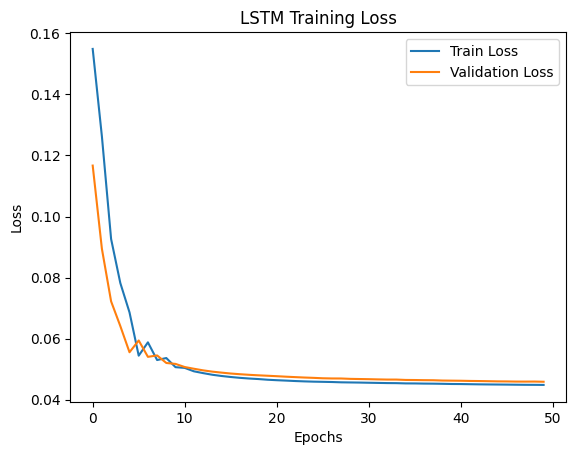

In [23]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

#### Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


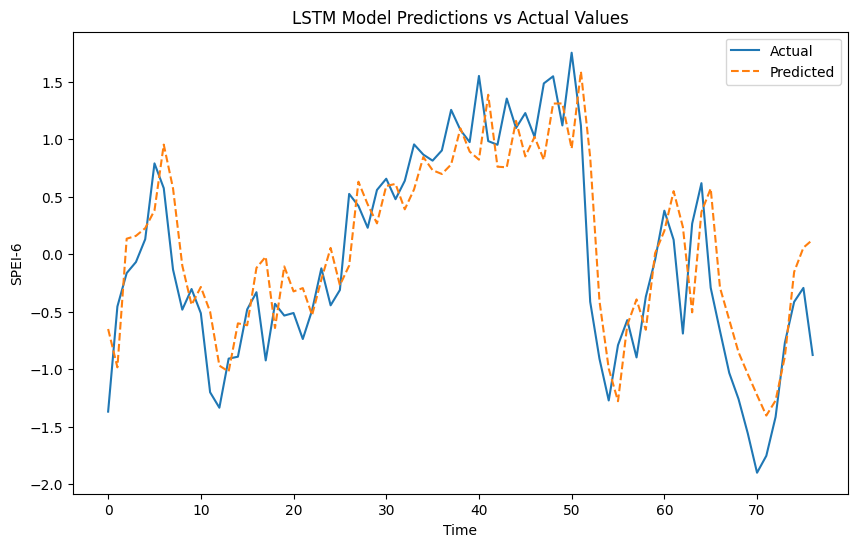

In [24]:
y_pred = LSTM_model.predict(X_test) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred_original, label="Predicted", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values")
plt.show()

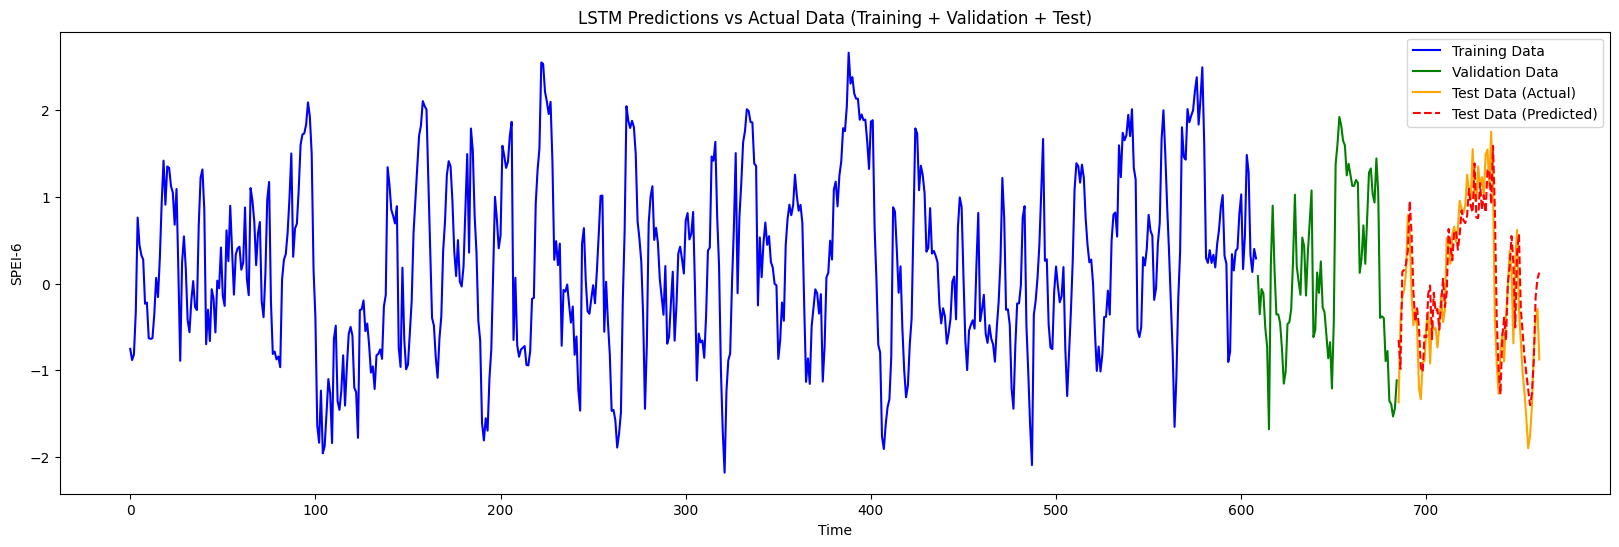

In [25]:
# reverse normalized SPEI values back to normal scale
# concatenate the training, validation, and test data
train_data1 = scaler.inverse_transform(y_train.reshape(-1, 1))
val_data1 = scaler.inverse_transform(y_val.reshape(-1, 1))
test_data1 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Concatenate the actual data (train + validation + test)
actual_data = np.concatenate((train_data1, val_data1, test_data1), axis=0)

# Concatenate the predicted data
# match this array with full data, but set training and validation set with NaN values | this will align the prediction data to only the testing data indices
predicted_data = np.concatenate((np.full_like(train_data1, np.nan),
                                 np.full_like(val_data1, np.nan),
                                 y_pred_original), axis=0)

# plot all data
plt.figure(figsize=(20, 6))

# plot training data
plt.plot(range(len(train_data1)), train_data1, label="Training Data", color='blue')

# plot validation data
plt.plot(range(len(train_data1), len(train_data1) + len(val_data1)), val_data1, label="Validation Data", color='green')

# plot test data (actual)
plt.plot(range(len(train_data1) + len(val_data1), len(actual_data)), test_data1, label="Test Data (Actual)", color='orange')

# plot predicted data (LSTM predictions)
plt.plot(range(len(train_data1) + len(val_data1), len(actual_data)), y_pred_original, label="Test Data (Predicted)", color='red', linestyle='--')


plt.xlabel('Time')
plt.ylabel('SPEI-6')
plt.legend()
plt.title('LSTM Predictions vs Actual Data (Training + Validation + Test)')
plt.show()

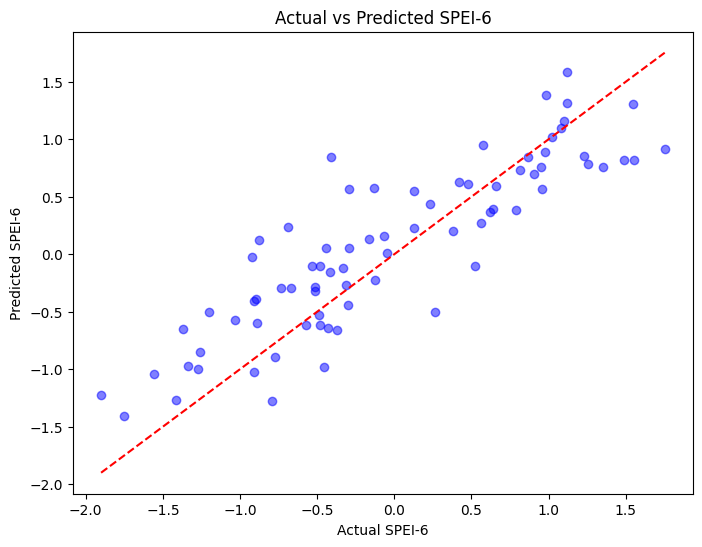

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.xlabel('Actual SPEI-6')
plt.ylabel('Predicted SPEI-6')
plt.title('Actual vs Predicted SPEI-6')
plt.show()

#### Metrics

In [27]:
# mean absolute error (MAE)
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.3646360388686361


In [28]:
# mean squared error (MSE)
mse = mean_squared_error(y_test_original, y_pred_original)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.20276759978672718


In [29]:
# root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.45029723493124757


In [30]:
# R^2
r2 = r2_score(y_test_original, y_pred_original)
print(f"R^2 Score: {r2}")

R^2 Score: 0.7470627063394547


#### Forecasting

In [31]:
# get the last sequence from the dataset to start forecasting
future_input = X_test[-1]  # last known data
future_predictions = []

num_forecast = 20  # forecast next 20 months

for _ in range(num_forecast):
    # Reshape input to fit model
    future_input = future_input.reshape(1, time_steps, 1)

    # Predict the next month
    next_pred = LSTM_model.predict(future_input)

    # Store prediction
    future_predictions.append(next_pred[0, 0])

    # Update future_input (slide the window forward)
    future_input = np.append(future_input[0, 1:], next_pred, axis=0)

# Convert predictions back to original scale
future_predictions_original = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [32]:
# Convert 'time' column to datetime if not already
spei6_df['time'] = pd.to_datetime(spei6_df['time'])

# Get test set time index
test_dates = spei6_df['time'].iloc[-len(y_test_original):]

# Generate future dates
last_date = test_dates.iloc[-1]  # Last known date
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=num_forecast, freq='M')


<ipython-input-32-bc581f904932>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=num_forecast, freq='M')


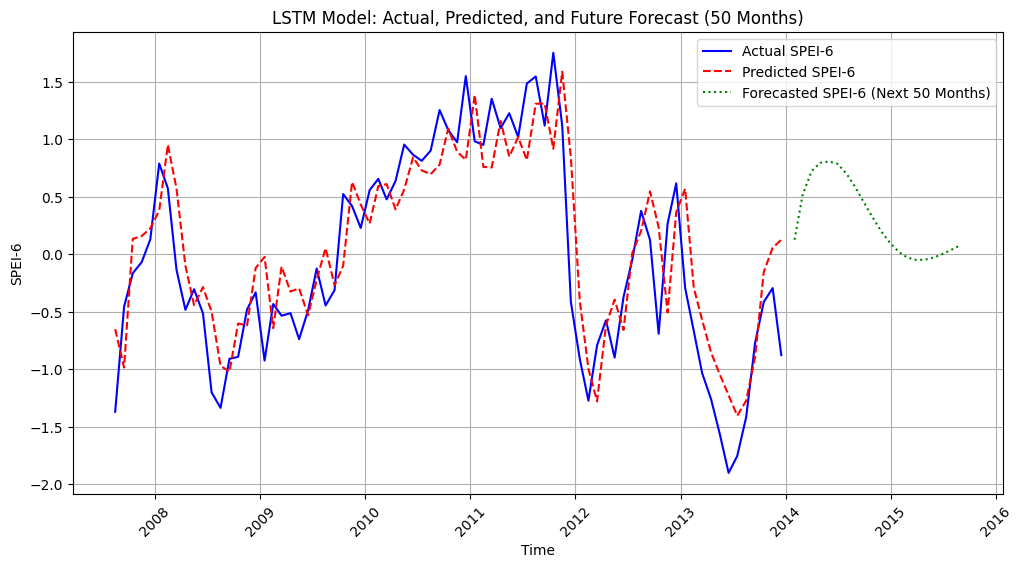

In [33]:
plt.figure(figsize=(12,6))

# Plot actual test values
plt.plot(test_dates, y_test_original, label="Actual SPEI-6", color="blue")

# Plot predicted test values
plt.plot(test_dates, y_pred_original, label="Predicted SPEI-6", color="red", linestyle="dashed")

# Plot future forecasted values
plt.plot(future_dates, future_predictions_original, label="Forecasted SPEI-6 (Next 50 Months)", color="green", linestyle="dotted")

plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.title("LSTM Model: Actual, Predicted, and Future Forecast (50 Months)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


### Fine-Tuning

#### No Batching

In [34]:
LSTM_model_v2 = Sequential()
LSTM_model_v2.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
LSTM_model_v2.add(LSTM(units=64, activation='relu'))
LSTM_model_v2.add(Dense(1))
LSTM_model_v2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_v2 = LSTM_model_v2.fit(X_train,
                         y_train,
                        #  batch_size=16,
                         validation_data=(X_val, y_val),
                         epochs=50,
                         verbose=1, # just determines how much info to display for each epoch
                         shuffle=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.1485 - val_loss: 0.1262
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1356 - val_loss: 0.1098
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1207 - val_loss: 0.0932
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1036 - val_loss: 0.0820
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0819 - val_loss: 0.0649
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0589 - val_loss: 0.0736
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0659 - val_loss: 0.0572
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0547 - val_loss: 0.0539
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0532 - val_loss: 0.0533
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0528 - val_loss: 0.0517
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0499 - val_loss: 0.0519
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0515 - val_l

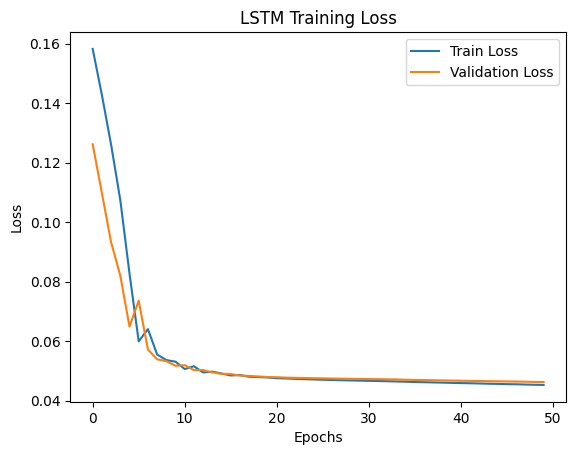

In [35]:
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

#### Dropout Layers

In [36]:
LSTM_model_v3 = Sequential()
LSTM_model_v3.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
LSTM_model_v3.add(Dropout(0.2))
LSTM_model_v3.add(LSTM(units=64, activation='relu'))
LSTM_model_v3.add(Dropout(0.2))
LSTM_model_v3.add(Dense(1))
LSTM_model_v3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history_v3 = LSTM_model_v3.fit(X_train,
                               y_train,
                               #  batch_size=16,
                               validation_data=(X_val, y_val),
                               epochs=50,
                               verbose=1, # just determines how much info to display for each epoch
                               shuffle=False)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.1504 - val_loss: 0.1268
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1365 - val_loss: 0.1087
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1196 - val_loss: 0.0905
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1000 - val_loss: 0.0764
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0832 - val_loss: 0.0650
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0727 - val_loss: 0.0583
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0637 - val_loss: 0.0581
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0641 - val_loss: 0.0573
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0631 - val_loss: 0.0575
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0637 - val_loss: 0.0615
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0631 - val_loss: 0.0569
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

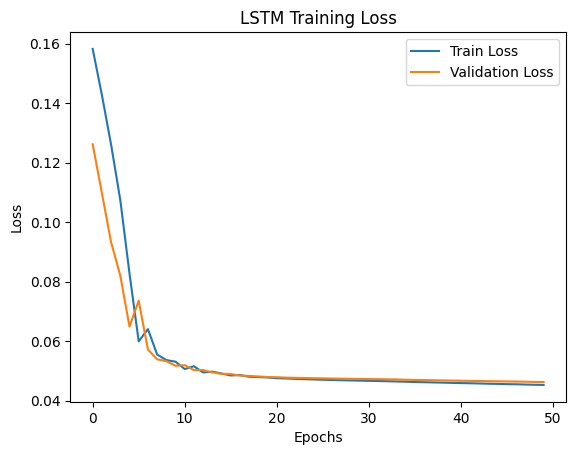

In [37]:
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

## SPEI-6 (corrected Fresno data)

### Data Preprocessing

In [38]:
spei6_df = pd.read_csv('/content/SPEI_6_MonthTimescale_1950_2013_FresnoCORRECT.csv')
spei6_df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: '/content/SPEI_6_MonthTimescale_1950_2013_FresnoCORRECT.csv'

In [ ]:
spei6_df.isnull().sum()

#### Normalize Data

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
spei6_df['spei'] = scaler.fit_transform(spei6_df[['spei']])
spei6_df.head(5)

#### Split Data

In [ ]:

def create_samples(data, time_steps=12):
  X, y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps)])
    y.append(data[i + time_steps])
  return np.array(X), np.array(y)

time_steps = 6
X, y = create_samples(spei6_df['spei'].values, time_steps)

# reshape input data (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape)
print(y.shape)

In [ ]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size : train_size + val_size], y[train_size : train_size + val_size]
X_test, y_test = X[train_size + val_size :], y[train_size + val_size :]


print(f"Training splits (80%):  X_train = {X_train.shape} | y_train = {y_train.shape}")
print(f"Validation splits (10%):  X_val = {X_val.shape} | y_val = {y_val.shape}")
print(f"Test splits (10%):  X_test = {X_test.shape} | y_test = {y_test.shape}")

In [ ]:
X_train[0], y_train[0]  # example sample

### Model Training

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


LSTM_model = Sequential()
LSTM_model.add(LSTM(units=64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
LSTM_model.add(LSTM(units=64, activation='relu'))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = LSTM_model.fit(X_train,
                         y_train,
                         batch_size=16,
                         validation_data=(X_val, y_val),
                         epochs=50,
                         verbose=1, # just determines how much info to display for each epoch
                         shuffle=False)

### Evaluation

In [ ]:
LSTM_model.summary()

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

In [ ]:
y_pred = LSTM_model.predict(X_test) # make predictions

# reverse normalized SPEI values back to normal scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# actual vs. predicted
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred_original, label="Predicted")
plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.legend()
plt.title("LSTM Model Predictions vs Actual Values")
plt.show()

#### Forecasting

In [ ]:
# get the last sequence from the dataset to start forecasting
future_input = X_test[-1]  # last known data
future_predictions = []

num_forecast = 20  # forecast next 50 months

for _ in range(num_forecast):
    # reshape input to fit model
    future_input = future_input.reshape(1, time_steps, 1)

    # predict the next month
    next_pred = LSTM_model.predict(future_input)

    # store prediction
    future_predictions.append(next_pred[0, 0])

    # update future_input (slide the window forward)
    future_input = np.append(future_input[0, 1:], next_pred, axis=0)

# convert predictions back to original scale
future_predictions_original = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


In [ ]:
# Convert 'time' column to datetime if not already
spei1_df['time'] = pd.to_datetime(spei1_df['time'])

# Get test set time index
test_dates = spei1_df['time'].iloc[-len(y_test_original):]

# Generate future dates
last_date = test_dates.iloc[-1]  # Last known date
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=num_forecast, freq='M')


In [ ]:
plt.figure(figsize=(12,6))

# plot actual test values
plt.plot(test_dates, y_test_original, label="Actual SPEI-6", color="blue")

# plot predicted test values
plt.plot(test_dates, y_pred_original, label="Predicted SPEI-6", color="red", linestyle="dashed")

# plot future forecasted values
plt.plot(future_dates, future_predictions_original, label="Forecasted SPEI-6 (Next 50 Months)", color="green", linestyle="dotted")

plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.title("LSTM Model: Actual, Predicted, and Future Forecast (50 Months)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [ ]:
def evaluate_model(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # percentage error

  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In [ ]:
evaluate_model(y_test_original, y_pred_original)